In [1]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [2]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.001
training_iters = 25000000
batch_size = 64
display_step = 20000
display_testing_step = 4000
keep_rate = 1

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 512 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [3]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [4]:
num_layers = 1

def RNN(x, W, b, n):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.LSTMCell(n, state_is_tuple = True)
    #lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)  
    #stacked_rnn = []
    #for i in range(num_layers):
        #stacked_rnn.append(tf.contrib.rnn.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(n, state_is_tuple=True), input_keep_prob=keep_prob)) 
    #stacked_rnn.append(tf.nn.rnn_cell.LSTMCell(n, state_is_tuple=True)) 
    

    #lstm_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)
        #lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)
                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']





In [20]:
# Launch the graph

#learning_rates = [1./10**i for i in range(1,7)]
learning_rates = [0.001]
#n_hidden = [2**i for i in range(4,10)]
#batch_sizes = [2**i for i in range(4,10)]
#keep_rates = [0.8 + 0.05 * i for i in range(4)]
keep_rates = [0.9]
training_iters = [i for i in range(29000000, 310000000, 1000000)]
#training_iters = 12000000
l = 0.001



results = {}
#loss_plots = {}

for k in keep_rates:
#for b in batch_sizes:

    results[k] = []
    #loss_plots[l] = {}
    
    for t in training_iters:
    #for l in learning_rates:    
        
        #loss_plots[l][k] = {}
        #loss_plots[l][k]['train'] = []
        #loss_plots[l][k]['valid'] = []
    
        tf.reset_default_graph()
        
        tf.set_random_seed(0.5)
        
        x = tf.placeholder("float", [None, n_steps, n_input])
        y = tf.placeholder("float", [None, n_classes])
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        # Define weights
        W = {
            'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
        }

        b = {
        'out': tf.Variable(tf.zeros([n_classes]))
        }
         
        pred = RNN(x, W, b, n=n_hidden)

        # Define loss and optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
        optimizer = tf.train.AdamOptimizer(learning_rate=l).minimize(cost)

        # Evaluate model
        correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            step = 1
            #losses = {'train':[], 'validation':[]}
            # Keep training until reach max iterations
            while step * batch_size < t:
                offset = (step * batch_size) % (y_train.shape[0] - batch_size)
                #offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)

                # Generate minibatches for training and validating.
                batch_x = x_train[offset:(offset + batch_size), :]
                batch_y = y_train[offset:(offset + batch_size), :]
                #batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
                #batch_val_y = y_test[offset_val:(offset_val + batch_size), :]

                # Reshape data to feed into RNN
                batch_x = batch_x.reshape((batch_size, n_steps, n_input))
                #batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))

                # Run optimization op (backprop)
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob:k})
                #loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob:k})
                #loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y, keep_prob:k})

                if step % display_step == 0:

                    print "Iter " + str(step*batch_size) #+ ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                    #      "{:.6f}".format(loss_test)

                #losses['train'].append(loss)
                #losses['validation'].append(loss_test)
                #loss_plots[l][k]['train'].append(loss)
                #loss_plots[l][k]['valid'].append(loss_test)
                
                step += 1

            print("Optimization Finished for  %d training iterations" % t )

            y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
            y_true = np.argmax(y_test,1)
            conf_matrix = met.confusion_matrix(y_true, y_pred)
            conf_bench = hm.getBenchmarkResults()
            metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
    
            results[k].append(metrics)

dump = pickle.dump(results, open( "tuning_results_1layer.p", "wb" ) )

print 'Finished optimization for all parameters!'


Iter 1280000
Iter 2560000
Iter 3840000
Iter 5120000
Iter 6400000
Iter 7680000
Iter 8960000
Iter 10240000
Iter 11520000
Iter 12800000
Iter 14080000
Iter 15360000
Iter 16640000
Iter 17920000
Iter 19200000
Iter 20480000
Iter 21760000
Iter 23040000
Iter 24320000
Iter 25600000
Iter 26880000
Iter 28160000
Optimization Finished for  29000000 training iterations
Iter 1280000
Iter 2560000
Iter 3840000
Iter 5120000
Iter 6400000
Iter 7680000
Iter 8960000
Iter 10240000
Iter 11520000
Iter 12800000
Iter 14080000
Iter 15360000
Iter 16640000
Iter 17920000
Iter 19200000
Iter 20480000
Iter 21760000
Iter 23040000
Iter 24320000
Iter 25600000
Iter 26880000
Iter 28160000
Iter 29440000
Optimization Finished for  30000000 training iterations


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda/envs/py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/anaconda/envs/py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/anaconda/envs/py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/anaconda/envs/py2/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/anaconda/envs/py2/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/anaconda/envs/py2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/anaconda/envs/py2/lib

IndexError: string index out of range

In [21]:
acc = {}
tpr_u2r = {}
tpr_r2l = {}
tpr_dos = {}
tpr_probe = {}
tpr_normal = {}

for key in results.keys():
    print key
    acc[key] = []
    tpr_u2r[key] = []
    tpr_r2l[key] = []
    tpr_dos[key] = []
    tpr_probe[key] = []
    tpr_normal[key] = []
    for entry in results[key]:
        acc[key].append(entry['accuracy_model'])
        tpr_u2r[key].append(entry['tpr_model'][3])
        tpr_r2l[key].append(entry['tpr_model'][4])
        tpr_probe[key].append(entry['tpr_model'][1])
        tpr_normal[key].append(entry['tpr_model'][0])
        tpr_dos[key].append(entry['tpr_model'][2])
        print entry['accuracy_model']


0.9
0.923849544576


In [7]:
for key in loss_plots.keys():
    dic = loss_plots[key]
    for sub_key in dic.keys():
        sub_dic = dic[sub_key]
        print sub_dic['valid']

[1.5856724, 1.566128, 1.5469037, 1.5227228, 1.5000212, 1.6039624, 1.6884146, 1.7039698, 1.7213224, 1.7408476, 1.7628319, 1.7874482, 1.8160093, 1.8485789, 1.8856349, 1.9282813, 1.9773277, 2.0336299, 2.1007268, 2.177845, 2.2686076, 2.3729072, 2.4943788, 2.6360979, 2.799067, 2.9831855, 3.1940367, 3.4308171, 3.688905, 3.9694541, 4.266994, 4.5874672, 4.921279, 5.2643991, 5.608202, 5.951314, 6.2895422, 6.6173162, 6.9372964, 7.2431469, 7.535984, 7.8143454, 8.0766182, 8.3232327, 8.5543108, 8.7682562, 8.9718666, 9.1589832, 9.3328819, 9.4942608, 9.6447344, 9.7839975, 9.9148531, 10.035522, 10.144491, 10.249764, 10.344502, 10.43164, 10.485354, 10.27026, 9.9369307, 7.0971899, 1.3679446, 1.6881202, 1.636271, 0.9632749, 1.4697206, 5.1701412, 4.6354809, 4.0690608, 3.5546038, 3.1145, 2.7307858, 2.4037237, 2.1386271, 1.9203693, 1.745739, 1.6038271, 1.4890006, 1.3955078, 1.3184979, 1.2540243, 1.1990627, 1.1511972, 1.1085526, 1.0696895, 1.0334842, 0.99912703, 0.96696097, 0.93973577, 0.91677272, 0.89739197

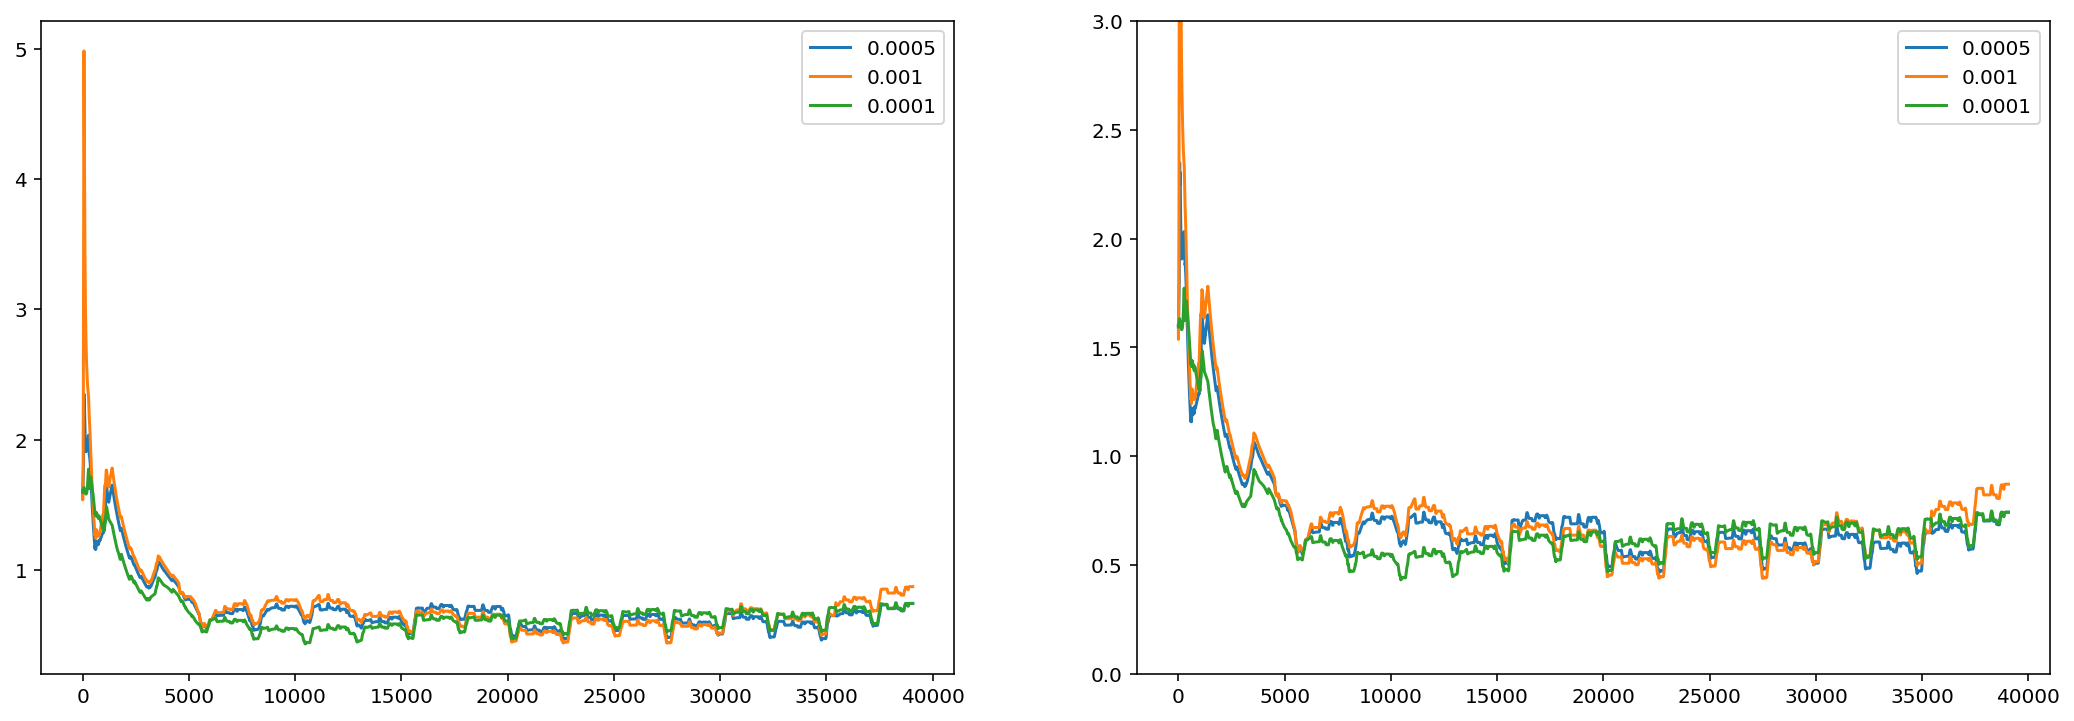

In [15]:

#smoothed_loss = hm.running_mean(losses['train'], 100)
#smoothed_loss_train = hm.running_mean(losses['validation'], 3050)

fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:2])


#for key in loss_plots[0.001].keys():
#    dic = loss_plots[0.001]
#    ax1.plot(dic[key]['valid'])

    
for key in loss_plots.keys():
    dic = loss_plots[key]
    for sub_key in dic.keys():
        sub_dic = dic[sub_key]
        ax1.plot(hm.running_mean(sub_dic['valid'],4500), label=key)
       
ax1.legend()


for key in loss_plots.keys():
    dic = loss_plots[key]
    for sub_key in dic.keys():
        sub_dic = dic[sub_key]
        ax2.plot(hm.running_mean(sub_dic['valid'],4500), label=key)
       
ax2.set_ylim(0,3)
ax2.legend()

plt.show()






In [12]:

fig.savefig('learningrate.pdf')

In [32]:
'''
Num_layers = 2

32 Batch Size
0.918528497343
0.919329065778
0.920300036331
0.919875638606
0.790006719631
0.918589584894
128
0.919869208337
0.920139279617
0.920345048211
0.920251809317
0.920364339017
0.922585996804
64
0.919393368464
0.921470345209
0.920447932508
0.922891434561
0.92343157712
0.923164720975
256
0.921370676046
0.922888219426
0.921049162618
0.921708265146
0.920422211434
0.92021644284
16
0.917059180977
0.920422211434
0.921476775478
0.920438287105
0.791398872774
0.916113931498
512
0.921447839269
0.921129540975
0.920049255857
0.921586090043
0.921312803629
0.9215539387

'''

'''
32
0.919663439744
0.922540984924
0.920827318353
0.922502403313
0.921521787357
0.922071575319
128
0.921010581007
0.921740416488
0.921557153835
0.919849917532
0.920132849348
0.920210012571
64
0.918821074562
0.920824103219
0.921033086947
0.921277437152
0.923280465809
0.923794887293
256
0.914985419366
0.919351571718
0.921425333329
0.921100604767
0.920383629822
0.92088519077
16
0.915744191056
0.919837056995
0.916721591877
0.919312990107
0.921743631623
0.922058714782
512
0.91675374322
0.918213414183
0.919621642998
0.922518478984
0.922087650991
0.921184198258
'''




'''

0.918743911339
0.91948017709
0.9235891187
0.924132476393
0.923817393233


15000000 - 28000000 



0.923926707799
0.924026376962
0.924341460121
0.924534368178
0.92398779535
0.92497162644
0.925125952885
0.924277157435
0.924373611464
0.924666188683
0.925019853454
0.925122737751
0.924752997309
0.92519668584


'''

'''


0.95
0.924736921638
0.924450774687
0.924801224323
0.924074603976
0.924093894782
0.9
0.924441129284
0.924113185587
0.924630822206
0.924894463217
0.925325291211
0.85
0.923778811622
0.924450774687
0.924733706503
0.92488160268
0.924714415698
0.8
0.922901079964
0.92416784287
0.924685479489
0.924373611464
0.924637252475

'''
'''
5000000 - 280000000

0.886203537291
0.900092917381
0.917708638101
0.918965755605
0.917812735369
0.918901452919
0.919714881892
0.923904201859
0.924203209347
0.924023161827
0.924090679647
0.923737014876
0.924209639616
0.924441129284
0.924113185587
0.924630822206
0.924894463217
0.925325291211
0.925325291211
0.925453896582
0.925158104228
0.925524629536
0.924425053612
0.924634037341
0.923849544576
0.923223582352




'''


'\n32\n0.919663439744\n0.922540984924\n0.920827318353\n0.922502403313\n0.921521787357\n0.922071575319\n128\n0.921010581007\n0.921740416488\n0.921557153835\n0.919849917532\n0.920132849348\n0.920210012571\n64\n0.918821074562\n0.920824103219\n0.921033086947\n0.921277437152\n0.923280465809\n0.923794887293\n256\n0.914985419366\n0.919351571718\n0.921425333329\n0.921100604767\n0.920383629822\n0.92088519077\n16\n0.915744191056\n0.919837056995\n0.916721591877\n0.919312990107\n0.921743631623\n0.922058714782\n512\n0.91675374322\n0.918213414183\n0.919621642998\n0.922518478984\n0.922087650991\n0.921184198258\n'

In [48]:
print acc

{0.001: [0.91876320214513763]}
